In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.integrate import trapezoid
import pandas as pd

In [2]:
def logistic_4p(x, min, max, ec50, h):
    return min + (max - min)/(1 + (x/ec50)**h)

In [3]:
def abs_ec50(min, max, ec50, h):
    return (((max - min)/(50 - min) - 1)**(1/h))*ec50

In [4]:
# define concentration series; 2-fold dilution
conc_range = [2e-8, 20e-6]
x = np.geomspace(*conc_range, 11)
x_fit = np.geomspace(*conc_range, 1000)
auc_conc = np.geomspace(1e-9, 5e-6, 1000) # AUC is quantified up to 5 uM

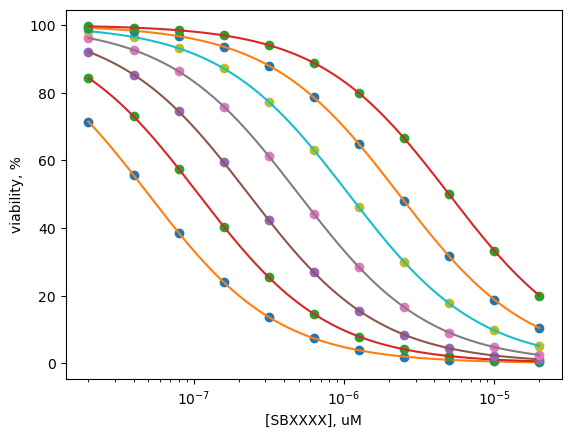

In [5]:
# all compounds are tested with the same dilution series
# create a range of perfect curves; quantify AUC over the whole concentration range
plt.xscale("log")
plt.xlabel('[SBXXXX], uM')
plt.ylabel('viability, %')
areas = []
for ec50 in np.geomspace(5e-8, 5e-6, 7):
    plt.plot(x, logistic_4p(x, 0, 100, ec50, 1), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, 0, 100, ec50, 1))
    area = trapezoid(logistic_4p(auc_conc, 0, 100, ec50, 1), auc_conc)
    areas.append(area)

In [6]:
# to normalize over the tested concentration range and express AUC as a fractional value
area_control = 100*(auc_conc[-1] - auc_conc[0])

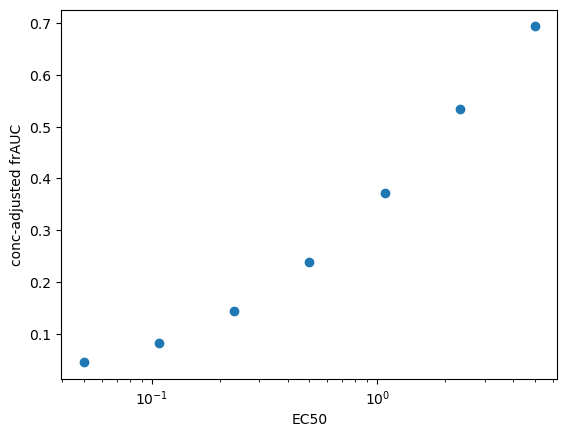

In [7]:
plt.xscale('log')
plt.xlabel('EC50')
plt.ylabel('conc-adjusted frAUC')
plt.plot(np.geomspace(5e-2, 5, 7),[area / area_control for area in areas], 'o')

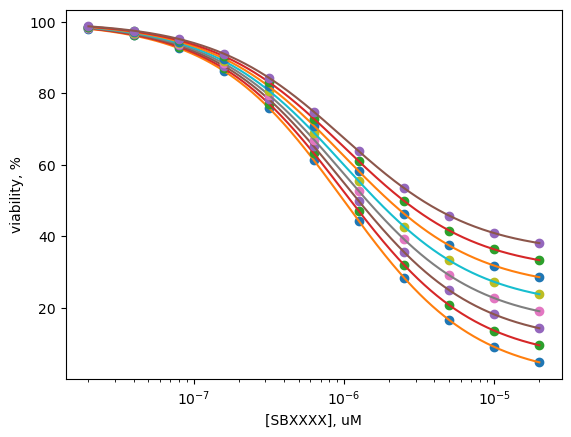

In [8]:
# bad curves: lower plateue differs for the same potency of 1 uM
# here we also quantify absolute ec50 values
plt.xscale("log")
plt.xlabel('[SBXXXX], uM')
plt.ylabel('viability, %')
areas = []
abs_ec50s = []
for min in np.linspace(0, 35, 8):
    plt.plot(x, logistic_4p(x, min, 100, 1e-6, 1), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, min, 100, 1e-6, 1))
    area = trapezoid(logistic_4p(auc_conc, min, 100, 1e-6, 1), auc_conc)
    areas.append(area)
    abs_ec50s.append(abs_ec50(min, 100, 1e-6, 1))

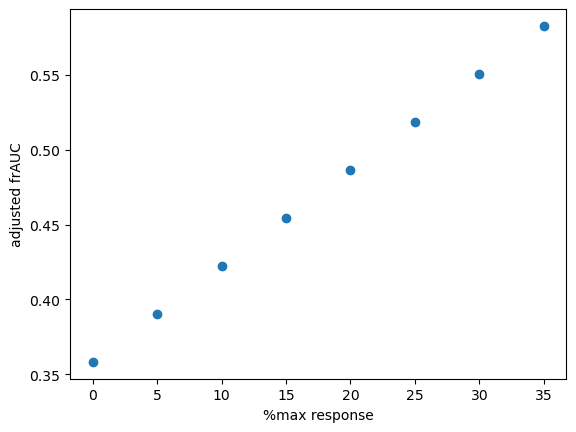

In [9]:
plt.xlabel('%max response')
plt.ylabel('adjusted frAUC')
plt.plot(np.linspace(0, 35, 8),[area / area_control for area in areas], 'o')
# AUC depends linearly from min - not a big surprise
# effect is not as strong, as for potency differences.
# AUC does not disciminate well between cytotox vs cytostatic/precipitation?
# Indeed it does not, since there are not enough concentration points at lower plateue region to inflate AUCs for bad curves

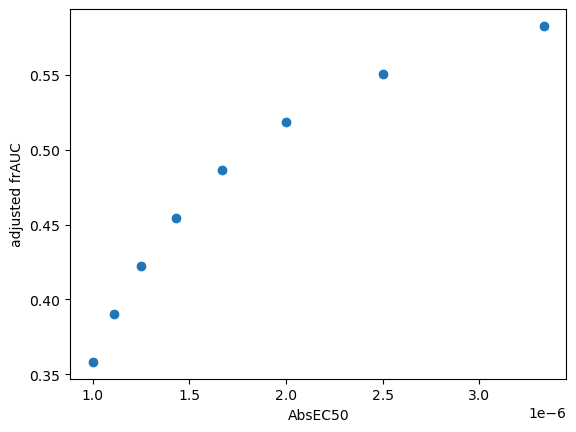

In [10]:
# A question - how does it correlate with the absolute EC50?
plt.xlabel('AbsEC50')
plt.ylabel('adjusted frAUC')
plt.plot(abs_ec50s,[area / area_control for area in areas], 'o')
# the effect is not that strong either.

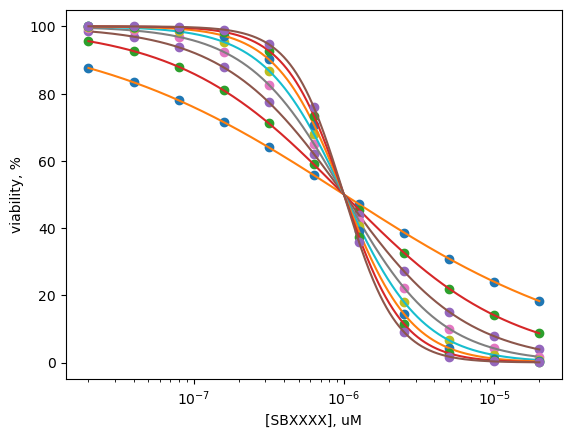

In [11]:
# bad curves: slope coefficient differs, potency same - 1 uM
plt.xscale("log")
plt.xlabel('[SBXXXX], uM')
plt.ylabel('viability, %')
areas = []
for h in np.linspace(0.5, 2.5, 8):
    plt.plot(x, logistic_4p(x, 0, 100, 1e-6, h), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, 0, 100, 1e-6, h))
    area = trapezoid(logistic_4p(auc_conc, 0, 100, 1e-6, h), auc_conc)
    areas.append(area)

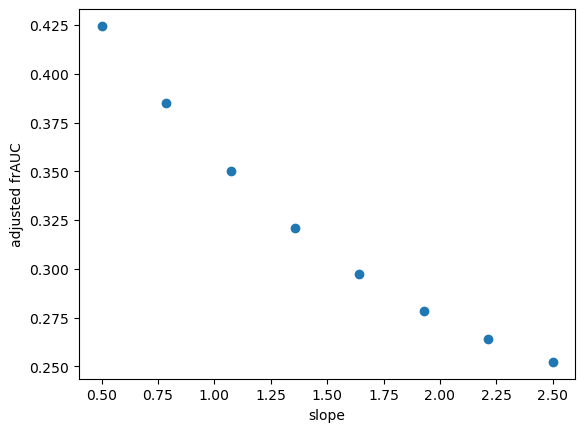

In [13]:
plt.xlabel('slope')
plt.ylabel('adjusted frAUC')
plt.plot(np.linspace(0.5, 2.5, 8),[area / area_control for area in areas], 'o')
# The effect of Hill-alike factor on AUC would be minimal if AUC is quantified 
# till higher conc, but for the shallow curves the values are inflated when the
# constrain is far from plateau
# If steep responses are ok for phenotyp readouts, remains a question.

In [14]:
# Let's generate a set of curves with values from a uniform distribution
# min from 0 to 50, h from 0.5 to 2.5, ec50 from 100 to 10000 nM

In [15]:
parameters = []
for i in range(0,1000):
    parameters.append([np.random.uniform(0,50), 100, np.random.uniform(1e-7,1e-5), np.random.uniform(0.5,2.5)])

In [24]:
all_data = pd.DataFrame()

In [26]:
all_data['Parameters'] = parameters

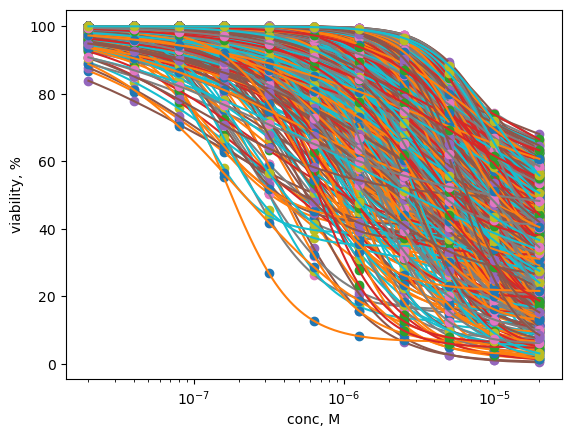

In [30]:
plt.xscale("log")
plt.xlabel('conc, M')
plt.ylabel('viability, %')
areas = []
for i in range(0,1000):
    plt.plot(x, logistic_4p(x, *all_data['Parameters'][i]), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, *all_data['Parameters'][i]))
    area = trapezoid(logistic_4p(auc_conc, *all_data['Parameters'][i]), auc_conc)
    areas.append(area)

In [32]:
fr_areas = [area / area_control for area in areas]

In [34]:
all_data['Adjusted frAUC'] = fr_areas

In [66]:
def starred_abs_ec50(set):
    return abs_ec50(*set)

In [68]:
all_data['min'] = all_data['Parameters'].apply(lambda value: value[0])
all_data['max'] = all_data['Parameters'].apply(lambda value: value[1])
all_data['EC50'] = all_data['Parameters'].apply(lambda value: value[2])
all_data['h'] = all_data['Parameters'].apply(lambda value: value[3])
all_data['absEC50'] = all_data['Parameters'].apply(starred_abs_ec50)

In [69]:
all_data

,Parameters,Adjusted frAUC,absEC50,min,max,EC50,h
0,"[28.656892100269143, 100, 6.465925322027434e-0...",0.866247,1.115272e-05,28.656892,100,6.465925e-06,1.561615
1,"[42.7458791846338, 100, 9.683071785352372e-06,...",0.912430,4.535134e-05,42.745879,100,9.683072e-06,1.250245
2,"[6.018622348786557, 100, 7.093001562217933e-07...",0.328614,7.995258e-07,6.018622,100,7.093002e-07,1.071127
3,"[24.403610216028326, 100, 4.086700997290918e-0...",0.783576,5.920188e-06,24.403610,100,4.086701e-06,1.806576
4,"[5.04681935872775, 100, 1.4356138038583561e-06...",0.453851,1.583905e-06,5.046819,100,1.435614e-06,1.082408
...,...,...,...,...,...,...,...
995,"[36.97702535547855, 100, 5.921732130221269e-06...",0.906595,1.057690e-05,36.977025,100,5.921732e-06,2.319323
996,"[40.837916991297746, 100, 4.591105414641622e-0...",0.791956,4.020942e-05,40.837917,100,4.591105e-06,0.782011
997,"[10.632753488776359, 100, 6.036582786534449e-0...",0.877575,6.661546e-06,10.632753,100,6.036583e-06,2.426963
998,"[5.775935715235747, 100, 7.917622063218818e-06...",0.768347,9.094056e-06,5.775936,100,7.917622e-06,0.886117


In [80]:
# top 10 compounds with lowest absEC50
top10_absec50 = all_data.sort_values(by='absEC50').head(10)

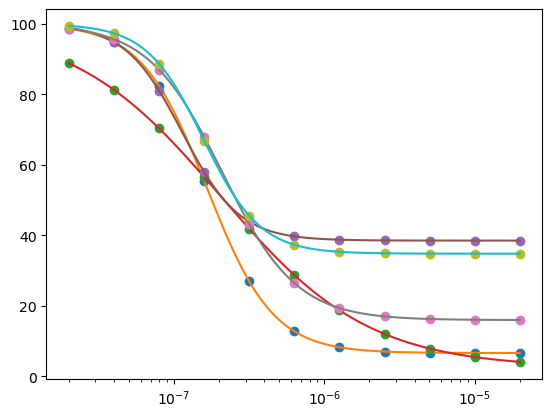

In [83]:
plt.xscale('log')
for i in range(0, 5):
    plt.plot(x, logistic_4p(x, *top10_absec50['Parameters'].iloc[i]), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, *top10_absec50['Parameters'].iloc[i]))    

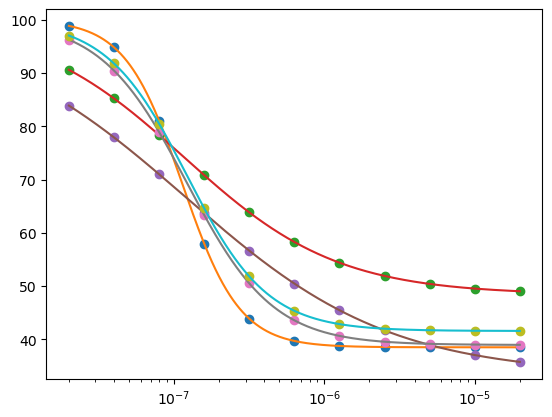

In [84]:
# top 10 compounds with lowest EC50
top10_ec50 = all_data.sort_values(by='EC50').head(10)
plt.xscale('log')
for i in range(0, 5):
    plt.plot(x, logistic_4p(x, *top10_ec50['Parameters'].iloc[i]), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, *top10_ec50['Parameters'].iloc[i]))   

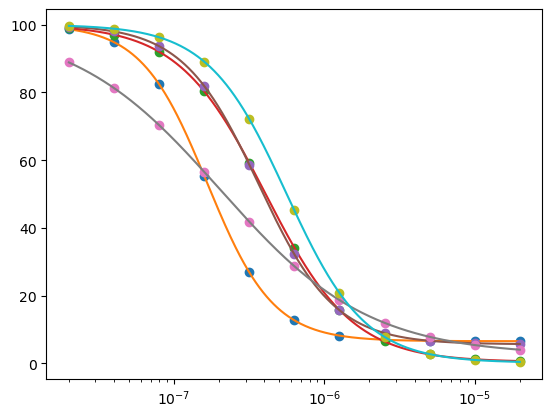

In [85]:
# top 10 compounds with lowest frAUC
top10_frauc = all_data.sort_values(by='Adjusted frAUC').head(10)
plt.xscale('log')
for i in range(0, 5):
    plt.plot(x, logistic_4p(x, *top10_frauc['Parameters'].iloc[i]), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, *top10_frauc['Parameters'].iloc[i]))   

In [86]:
top10_ec50

,Parameters,Adjusted frAUC,absEC50,min,max,EC50,h
684,"[38.485556233336865, 100, 1.1348787928858317e-...",0.404230,2.158570e-07,38.485556,100,1.134879e-07,2.283986
977,"[48.37614241822322, 100, 1.1670901177633696e-0...",0.541272,6.526671e-06,48.376142,100,1.167090e-07,0.851701
217,"[33.289085453914794, 100, 1.2010356132525708e-...",0.442990,6.692004e-07,33.289085,100,1.201036e-07,0.638029
260,"[38.9188094808669, 100, 1.2150250624291876e-07...",0.419947,3.284182e-07,38.918809,100,1.215025e-07,1.515331
745,"[41.548685808692014, 100, 1.2196302902496544e-...",0.442689,3.650887e-07,41.548686,100,1.219630e-07,1.621365
622,"[32.36310916722328, 100, 1.3911645304537488e-0...",0.418649,5.319210e-07,32.363109,100,1.391165e-07,0.776948
834,"[34.76880292911656, 100, 1.5678945388061382e-0...",0.375923,2.628691e-07,34.768803,100,1.567895e-07,2.300285
667,"[41.338151009227346, 100, 1.5893533368494727e-...",0.441480,3.750206e-07,41.338151,100,1.589353e-07,2.042083
555,"[6.5678092911025665, 100, 1.6629932977720043e-...",0.113605,1.785324e-07,6.567809,100,1.662993e-07,1.983942
125,"[43.69068828065924, 100, 1.7096512427799467e-0...",0.466897,4.916446e-07,43.690688,100,1.709651e-07,1.959674


In [87]:
top10_absec50

,Parameters,Adjusted frAUC,absEC50,min,max,EC50,h
555,"[6.5678092911025665, 100, 1.6629932977720043e-...",0.113605,1.785324e-07,6.567809,100,1.662993e-07,1.983942
740,"[2.3680324893449125, 100, 2.0406517904911693e-...",0.172799,2.156178e-07,2.368032,100,2.040652e-07,0.881071
684,"[38.485556233336865, 100, 1.1348787928858317e-...",0.404230,2.158570e-07,38.485556,100,1.134879e-07,2.283986
58,"[15.919769211798645, 100, 2.0912307806806466e-...",0.219169,2.600357e-07,15.919769,100,2.091231e-07,1.759123
834,"[34.76880292911656, 100, 1.5678945388061382e-0...",0.375923,2.628691e-07,34.768803,100,1.567895e-07,2.300285
268,"[14.228525301981598, 100, 2.5630342362497036e-...",0.228841,3.206025e-07,14.228525,100,2.563034e-07,1.496034
244,"[12.257739013461034, 100, 2.761657769815691e-0...",0.199599,3.207971e-07,12.257739,100,2.761658e-07,1.877358
260,"[38.9188094808669, 100, 1.2150250624291876e-07...",0.419947,3.284182e-07,38.918809,100,1.215025e-07,1.515331
120,"[1.3036998246816422, 100, 3.374316833460083e-0...",0.268230,3.511653e-07,1.303700,100,3.374317e-07,0.662255
745,"[41.548685808692014, 100, 1.2196302902496544e-...",0.442689,3.650887e-07,41.548686,100,1.219630e-07,1.621365


In [88]:
top10_frauc

,Parameters,Adjusted frAUC,absEC50,min,max,EC50,h
555,"[6.5678092911025665, 100, 1.6629932977720043e-...",0.113605,1.785324e-07,6.567809,100,1.662993e-07,1.983942
37,"[0.419420985355895, 100, 4.049374863640019e-07...",0.153670,4.072226e-07,0.419421,100,4.049375e-07,1.496992
595,"[5.647485589140033, 100, 3.6659386700673243e-0...",0.172391,3.930717e-07,5.647486,100,3.665939e-07,1.718641
740,"[2.3680324893449125, 100, 2.0406517904911693e-...",0.172799,2.156178e-07,2.368032,100,2.040652e-07,0.881071
382,"[0.20105723832062328, 100, 5.610636724820157e-...",0.185464,5.624268e-07,0.201057,100,5.610637e-07,1.660408
60,"[0.8840875589273545, 100, 5.081318684453179e-0...",0.199335,5.147226e-07,0.884088,100,5.081319e-07,1.384326
244,"[12.257739013461034, 100, 2.761657769815691e-0...",0.199599,3.207971e-07,12.257739,100,2.761658e-07,1.877358
58,"[15.919769211798645, 100, 2.0912307806806466e-...",0.219169,2.600357e-07,15.919769,100,2.091231e-07,1.759123
846,"[4.783083111105868, 100, 6.49439477558703e-07,...",0.220136,6.808547e-07,4.783083,100,6.494395e-07,2.128562
268,"[14.228525301981598, 100, 2.5630342362497036e-...",0.228841,3.206025e-07,14.228525,100,2.563034e-07,1.496034


In [102]:
absec50_and_frauc = top10_absec50.index.intersection(top10_frauc.index)
absec50_and_frauc

Index([555, 740, 58, 268, 244], dtype='int64')

In [103]:
ec50_and_frauc = top10_ec50.index.intersection(top10_frauc.index)
ec50_and_frauc

Index([555], dtype='int64')

In [105]:
absec50_and_ec50 = top10_absec50.index.intersection(top10_ec50.index)
absec50_and_ec50

Index([555, 684, 834, 260, 745], dtype='int64')